In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [2]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

# forecasting air passengers

we have the monthly info for air passengers of certain airline, from 1949 to 1960, first will forcast with $ARIMA$ then with $SARIMA$ to see the difference

In [3]:
df = pd.read_csv('air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


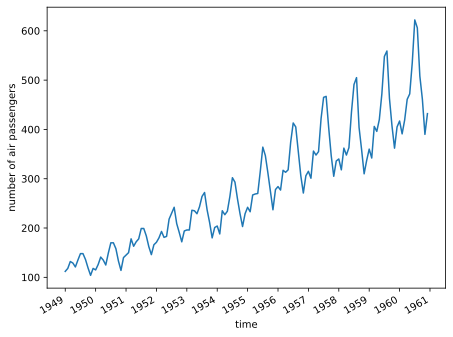

In [4]:
fig, ax = plt.subplots()

ax.plot(df.Passengers)

ax.set_xlabel('time')
ax.set_ylabel('number of air passengers')

ax.set_xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962, 1),
)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

We can see that it seems there is a pattern that repeats every year

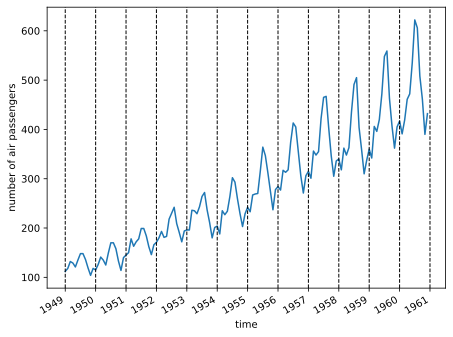

In [5]:
fig, ax = plt.subplots()

ax.plot(df.Passengers)

ax.set_xlabel('time')
ax.set_ylabel('number of air passengers')

ax.set_xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962, 1),
)

# draw line every year
for i in np.arange(0, 145, 12):
    ax.axvline(x = i, linestyle = '--', color = 'black', linewidth = 1)
    
fig.autofmt_xdate()
plt.tight_layout()

another way of seeing the seasonability is by decomposing the time series:

In [6]:
# the period is equal to the frequency
# STL stands for Season-Trend decomposition using LOESS.
decomposition = sm.tsa.STL(df.Passengers, period = 12).fit()

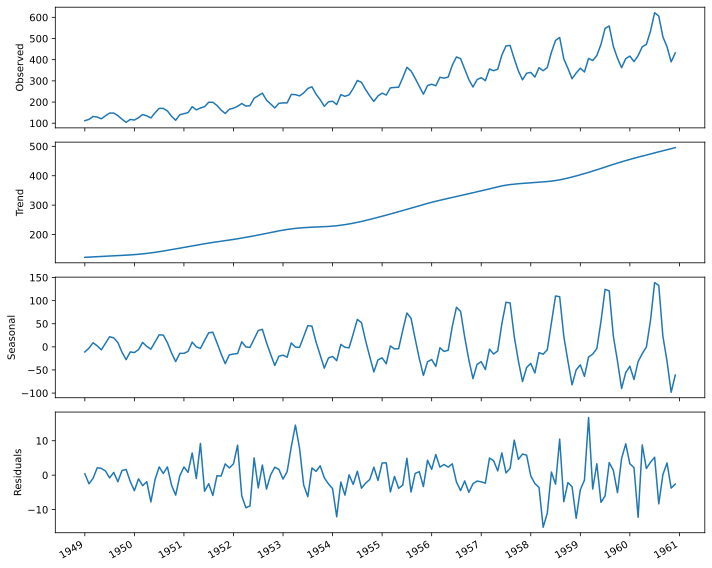

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows = 4, ncols = 1, 
    sharex = True, 
    figsize=(10,8)
) 

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

You can see that the y-axis are diff for the four plots; this is because each plot shows the magnitude of change that is attributed to that particular component. Meaning the sum of the residuals, seasonal, and trend data become the observed data.

Well we know the drill by now, let's test for stationarity

### check for stationarity

In [8]:
adf = sm.tsa.stattools.adfuller(df.Passengers)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic 0.8153688792060421
p-value 0.9918802434376409


adf statistic is not a large negative value, and $p$ value is larger than 0.05, therefore we cannot reject the null hypothesis meaning that our time series is not stationary

I bet no one was surprised by this result, so let's see how many diff we need to apply to make it stationary.

In [9]:
passengers_diff = np.diff(df.Passengers, n = 1)
adf = sm.tsa.stattools.adfuller(passengers_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -2.829266824169981
p-value 0.05421329028382792


Seems that still nope

In [10]:
passengers_diff = np.diff(df.Passengers, n = 2)
adf = sm.tsa.stattools.adfuller(passengers_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -16.384231542468513
p-value 2.7328918500142026e-29


That looks more like it $p < 0.05$ so we can reject the null hypothesis meaning that our time series is now stationary and $d = 2$

## doing arima before sarima

### find p, q and P, Q

Now we need to get the values of $p$ and $q$, we will make all posible combinations from 0 to to 12; why 12? becuase we hypothesize that the value of January will like be related to the value of last year's January, since we have 12 data point in between, let's test this. Also we will be setting $PDQ$ to 0 for now

In [11]:
ps = range(0, 12) 
qs = range(0, 12)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

# list with all combinations posible for p,q,P,Q
order_l = list(itertools.product(ps, qs, Ps, Qs))

In [12]:
import tqdm
def optimize_sarima(
        endog: pd.Series | list, order_l: list, 
        d: int, D: int, s:int) -> pd.DataFrame:

    '''
    Given a list of combinations of p,q test different combinations of arma
    orders, and compare them against each other using Akaike Information
    criterion.

    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param order_l list: list of all combinations of p and q
    :param d int: number of times the dataset needs to be diff to become 
                  stationary 

    :returns: dataframe with two columns, one the combination of p and q,
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in tqdm.tqdm_notebook(order_l):
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog, 
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

## find best `p` and `q` for arima

In [13]:
train = df.Passengers[:-12]

In [56]:
arima_result = optimize_sarima(train, order_l, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

In [15]:
arima_result

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.841494
1,"(11, 4, 0, 0)",1019.018559
2,"(11, 5, 0, 0)",1020.377421
3,"(11, 1, 0, 0)",1021.028121
4,"(11, 7, 0, 0)",1021.662835
...,...,...
139,"(5, 0, 0, 0)",1281.732157
140,"(3, 0, 0, 0)",1300.282335
141,"(2, 0, 0, 0)",1302.913196
142,"(1, 0, 0, 0)",1308.152194


We can see that $p=11, d=2, q=3$ now we will fit $ARIMA(11,2,3)$ and obtain the residuals

In [16]:
model = sm.tsa.statespace.SARIMAX(
    train, 
    order = (11, 2, 3),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

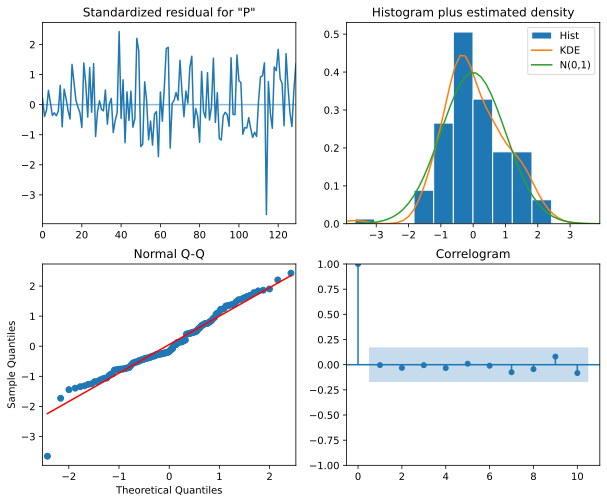

In [17]:
model.plot_diagnostics(figsize=(10, 8));

Top right does not have any trend, and Q-Q plot it almost $y=x$ meaning the residuals behave as white noise. We need to do the Ljung-Box statistic

In [18]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,6.552293,0.010475
2,6.678860,0.035457
3,6.956451,0.073299
4,7.749724,0.101189
5,8.393443,0.135844
6,8.679005,0.192452
7,9.492709,0.219189
8,9.731010,0.284415
9,9.741355,0.371827
10,11.533586,0.317483


since p value is smaller than 0.05 starting from lag 3, the residuals are uncorrelated starting at lag 3.
> The returned p-values are all greater than 0.05 except for the first two values. This means that, according to the Ljung-Box test, we reject the null hypothesis with a 5% chance of being wrong, since we set our significance boundary to 0.05. However, the third value and onwards are all greater than 0.05, so we reject the null hypothesis, con- cluding that the residuals are uncorrelated starting at lag 3.

In [19]:
test = df.iloc[-12:]

In [20]:
# The naive seasonal forecast simply reuses the data from 1959 as
# a forecast for 1960.
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values

In [21]:
arima_pred = model.get_prediction(132, 143).predicted_mean
test['arima_pred'] = arima_pred

In [22]:
test

,Month,Passengers,naive_seasonal,arima_pred
132,1960-01,417,360,422.336768
133,1960-02,391,342,410.648349
134,1960-03,419,406,461.838160
135,1960-04,461,396,457.794892
136,1960-05,472,420,481.668433
137,1960-06,535,472,531.058511
138,1960-07,622,548,606.146120
139,1960-08,606,559,615.455753
140,1960-09,508,463,525.628588
141,1960-10,461,407,467.144534


### arima forecast

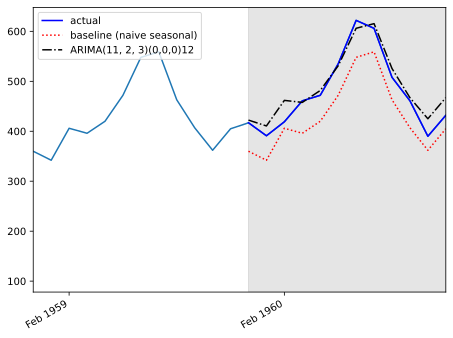

In [23]:
fig, ax = plt.subplots()

ax.plot(df.Passengers)
ax.plot(test.Passengers, 'b', label = 'actual')
ax.plot(test.naive_seasonal, 'r:', label = 'baseline (naive seasonal)')
ax.plot(test.arima_pred, 'k-.', label = 'ARIMA(11, 2, 3)(0,0,0)12')

ax.legend(loc = 2)

ax.axvspan(132, 143, color='#808080', alpha = 0.2)

ax.set_xlim(120, 143)


plt.xticks(
    [122, 134],
    ['Feb 1959', 'Feb 1960'],
)

fig.autofmt_xdate()
plt.tight_layout()

Now we will do the same but using SARIMA

## sarima

we first need to find the order of differencing, we test for stationarity again

In [24]:
adf = sm.tsa.stattools.adfuller(df.Passengers)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic 0.8153688792060421
p-value 0.9918802434376409


Since the value of p is larger than 0.05 we cannot reject the null hypothesis meaning the series is not stationary.

In [25]:
passengers_diff = np.diff(df.Passengers, n = 1)
adf = sm.tsa.stattools.adfuller(passengers_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -2.829266824169981
p-value 0.05421329028382792


Again, even with a first order diff we cannot reject the null hypothesis meaning the series is not stationary. Therefore, let’s apply a seasonal difference and test for stationarity.

In [27]:
# Seasonal differencing. Since we have monthly data, m = 12, so the
# seasonal difference is the difference between two values that are
# 12 timesteps apart.

passengers_diff_seasonal_diff = np.diff(passengers_diff, n = 12)
adf = sm.tsa.stattools.adfuller(passengers_diff_seasonal_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -17.624862360092017
p-value 3.8230468562850304e-30


we can now reject the null hypothesis meaning that, $d=1$ since we did just one round of diff, and $D=1$ since we did one round of seasonal diff on top of that

In [28]:
ps = range(0, 4) 
qs = range(0, 4)
Ps = range(0, 4)
Qs = range(0, 4)

d = 1
D = 1
s = 12

# list with all combinations posible for p,q,P,Q
order_l = list(itertools.product(ps, qs, Ps, Qs))

In [29]:
train = df.Passengers[:-12]
arima_result = optimize_sarima(train, order_l, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

In [30]:
arima_result

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.241029
1,"(2, 1, 2, 1)",893.571351
2,"(2, 1, 1, 3)",894.093579
3,"(1, 0, 1, 2)",894.291626
4,"(0, 1, 1, 2)",894.990537
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.486232
253,"(0, 0, 3, 0)",908.742583


We can see that $SARIMA(2,1,1)(1,1,2)_{12}$ is the way to go, since it had the lowest AIC. We now can fit the model

In [37]:
model = sm.tsa.statespace.SARIMAX(
    train, 
    order = (2, 1, 1),
    seasonal_order = (1, 1, 2, 12),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

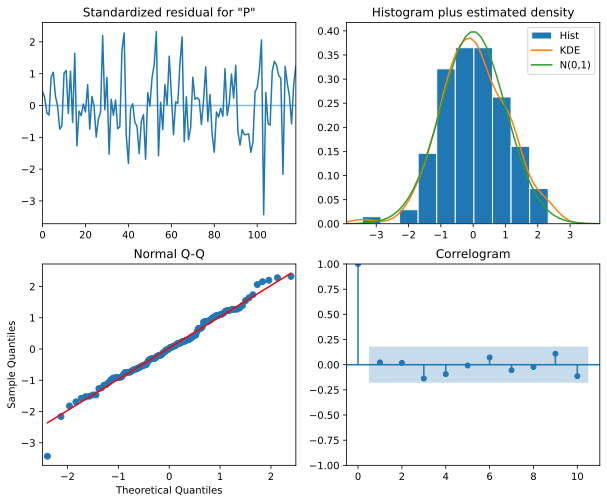

In [38]:
model.plot_diagnostics(figsize = (10, 8))
plt.show()

from a qualitative standpoint, our residuals resemble white noise, which is a good thing. top left plot does not have any trend, bottom left y is almost equal to x, bottom right no significant correlation besides from first lag, so we are clear from this side. Now let's get the Ljung-Box statistic to see if the residuals are correlated.

In [39]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,0.004892,0.944238
2,0.745146,0.688959
3,1.021992,0.795931
4,1.225859,0.873823
5,1.435186,0.920426
6,1.712160,0.944179
7,2.309047,0.940777
8,2.718463,0.950765
9,2.734946,0.973884
10,4.968908,0.893245


All values are larger than 0.05 therefore we cannot reject the null hypothesis, we conclude that the residuals are independent and uncorrelated, just like white noise.

In [40]:
sarima_pred = model.get_prediction(132, 143).predicted_mean
test['sarima_pred'] = sarima_pred

In [41]:
test

,Month,Passengers,naive_seasonal,arima_pred,sarima_pred
132,1960-01,417,360,422.336768,418.505704
133,1960-02,391,342,410.648349,399.561859
134,1960-03,419,406,461.838160,461.296271
135,1960-04,461,396,457.794892,451.427696
136,1960-05,472,420,481.668433,473.725202
137,1960-06,535,472,531.058511,538.790479
138,1960-07,622,548,606.146120,612.454271
139,1960-08,606,559,615.455753,624.617115
140,1960-09,508,463,525.628588,520.164519
141,1960-10,461,407,467.144534,462.831620


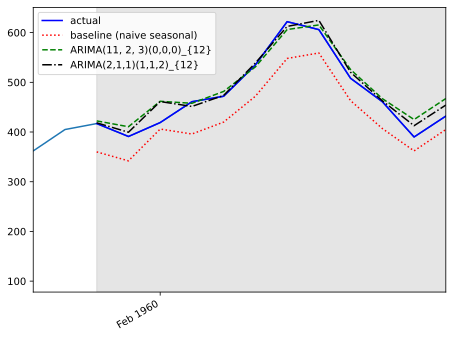

In [49]:
fig, ax = plt.subplots()

ax.plot(df.Passengers)
ax.plot(test.Passengers, 'b', label = 'actual')
ax.plot(test.naive_seasonal, 'r:', label = 'baseline (naive seasonal)')
ax.plot(test.arima_pred, 'g--', label = 'ARIMA(11, 2, 3)(0,0,0)_{12}')
ax.plot(test.sarima_pred, 'k-.', label = 'ARIMA(2,1,1)(1,1,2)_{12}')


ax.legend(loc = 2)

ax.axvspan(132, 143, color='#808080', alpha = 0.2)

ax.set_xlim(130, 143)


plt.xticks(
    [134],
    ['Feb 1960'],
)

fig.autofmt_xdate()
plt.tight_layout()

In [50]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_arima = mape(test['Passengers'], test['arima_pred'])
mape_sarima = mape(test['Passengers'], test['sarima_pred'])

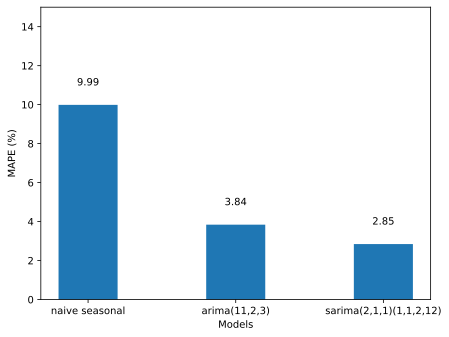

In [55]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'arima(11,2,3)', 'sarima(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_arima, mape_sarima]


ax.bar(x, y, width = 0.4)

ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(
        x = index, y = value + 1, s = str(round(value,2)), ha = 'center'
    )
    
plt.tight_layout()